# Fig S5: Shape descriptors as a function of distance from the fovea

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-04 15:08:12,702 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
features = []
targets = []
for subject in subjects:
    f, t = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'),
                                  subject=subject, amp=2.0, random_state=42)
    f, t = argus_shapes.calc_mean_images(f, t, max_area=1.5)
    xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
                        np.diff(subjectdata.loc[subject, 'yrange'])[0]])
    t['area'] = [y['area'] / np.prod(x['img_shape']) * np.prod(xyrange)
                 for (_, x), (_, y) in zip(f.iterrows(), t.iterrows())]
    t['orientation'] = np.rad2deg(t['orientation'])
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    t['dist2fovea'] = [np.sqrt(argus[row['electrode']].x_center ** 2 + 
                               argus[row['electrode']].y_center ** 2)
                       for _, row in t.iterrows()]
    features.append(f)
    targets.append(t)

In [5]:
Xy = pd.concat((pd.concat(features), pd.concat(targets).drop(columns='electrode')), axis=1)
gb = Xy.groupby('subject')

In [6]:
cols = ['area', 'orientation', 'eccentricity', 'compactness']
ylabels = ['area (deg$^2$)', 'orientation (deg)', 'elongation', 'compactness']
markers = ['o', 's', 'v', '^']
# colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

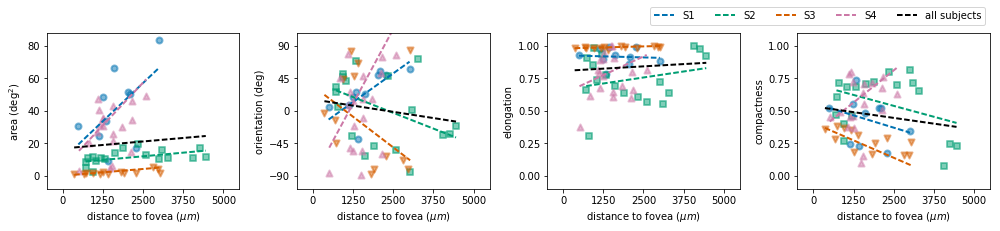

In [7]:
yticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
ylimits = [[-8, 88], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
    
fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim, ytick in zip(cols, axes, ylabels, ylimits, yticks):
    d2f = []
    ycol = []
    for (subject, data), marker in zip(gb, markers):
        ax.scatter(data['dist2fovea'], data[col], alpha=0.5, marker=marker,
                   linewidth=2, label=None)
        # Linear fit for subject:
        slope, intercept, rval, pval, _ = stats.linregress(data['dist2fovea'], data[col])
        reg = lambda x: x * slope + intercept
        a = ax.axis()
        ax.plot([np.min(data['dist2fovea']), np.max(data['dist2fovea'])],
                [reg(a[0]), reg(a[1])], '--', linewidth=2, label=subject)
        d2f += list(data['dist2fovea'])
        ycol += list(data[col])
        
    # Linear fit across all subjects:
    d2f = np.array(d2f)
    ycol = np.array(ycol)
    slope, intercept, rval, pval, _ = stats.linregress(d2f, ycol)
    reg = lambda x: x * slope + intercept
    a = ax.axis()
    ax.plot([np.min(d2f), np.max(d2f)], [reg(a[0]), reg(a[1])],
            'k--', linewidth=2, label='all subjects')
    
    ax.set_xlim(-500, 5500)
    ax.set_xticks(np.linspace(0, 5000, 5))
    ax.set_xlabel('distance to fovea ($\mu m$)')
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ytick, num=5))
    ax.set_ylabel(ylabel)
    if col == 'compactness':
        ax.legend(loc='upper right', ncol=5, bbox_to_anchor=(1, 1.2))

fig.tight_layout()
fig.savefig('fig5a-fovea.eps')

In [8]:
for col in cols:
    print(col)
    d2f = []
    ycol = []
    for subject, data in gb:
        _, _, rval, pval, _ = stats.linregress(data['dist2fovea'], data[col])
        d2f += list(data['dist2fovea'])
        ycol += list(data[col])
        print('%s: r=%.3f, p=%f' % (subject, rval, pval))
    _, _, rval, pval, _ = stats.linregress(d2f, ycol)
    print('All subjects: r=%.2f, p=%f\n' % (rval, pval))

area
S1: r=0.528, p=0.116678
S2: r=0.461, p=0.054376
S3: r=0.643, p=0.017678
S4: r=0.344, p=0.149044
All subjects: r=0.08, p=0.557820

orientation
S1: r=0.690, p=0.027248
S2: r=-0.390, p=0.109543
S3: r=-0.266, p=0.380257
S4: r=0.347, p=0.145606
All subjects: r=-0.11, p=0.410718

eccentricity
S1: r=-0.067, p=0.853042
S2: r=0.216, p=0.389361
S3: r=0.410, p=0.164043
S4: r=0.166, p=0.497346
All subjects: r=0.07, p=0.605023

compactness
S1: r=-0.273, p=0.444625
S2: r=-0.329, p=0.182016
S3: r=-0.677, p=0.011011
S4: r=0.228, p=0.348469
All subjects: r=-0.14, p=0.298299

